# PyTorch Workflow

Explore an example PyTorch end-to-end workflow.

Ressources:
* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version: https://www.learnpytorch.io/01_pytorch_workflow/
* Ask a question: https://github.com/mrdbourke/pytorch-deep-learning/discussions/

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png)

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "Fiiting the model to data (training)",
                      4: "making predictions and evaluate a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'Fiiting the model to data (training)',
 4: 'making predictions and evaluate a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn # neural network module
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# check PyTorch version
torch.__version__

'2.6.0+cpu'

In [3]:
!nvidia-smi

Mon Feb 10 16:52:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.03                 Driver Version: 561.03         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   55C    P8             16W /  115W |     860MiB /   6144MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Data (preparing and loading)

Data can be almost anything ... in machine learning

* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text
* ... 
 
 ML is a game of two parts:
 1. Get data into numerical representation.
 2. Build a model to learn patterns in that numerical representation.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-machine-learning-a-game-of-two-parts.png)

To showcaes this, let's create some *known* showcase data using linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**.

\begin{equation}
Y_i = f(X_i, \beta) + e_i
\end{equation}

In [4]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create 
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets
(One of the most important concepts in machine learning in general)

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [6]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, ..."

In [7]:
# Create plot of y above X
def plot_predictions(train_data=X_train,
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    
    """ Plots training data, test data and compares predictions. """
    
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c='b', label='Training data')
    plt.scatter(test_data, test_labels, c='g', label='Testing data')
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', label='Predictions')
    plt.legend()
    plt.show()  


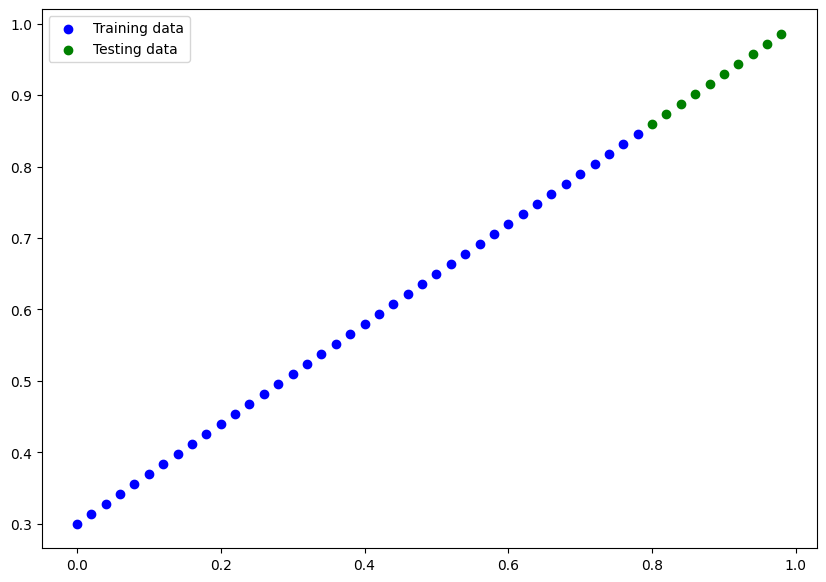

In [8]:
# Create plot of training and test data
plot_predictions(train_data=X_train, 
                 train_labels=y_train, 
                 test_data=X_test, 
                 test_labels=y_test)

## 2. Build model

Our first Pytorch model!

Because we are going to be building classes throughout the course, I'd recommend getting familiar with OOP in Python, to do so you can use the following resource from Real Python...

What the model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represint (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [9]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module):
    """
    This class represents a linear regression model in PyTorch. It inherits from the `nn.Module` class
    and implements the necessary methods for defining the computation in the model.
    
    Attributes:
        weights (nn.Parameter): The weight parameter of the linear regression model.
        bias (nn.Parameter): The bias parameter of the linear regression model.
    """
    
    def __init__(self):
        super().__init__()
        
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Forward method to define the computation in the model. """
        return self.weights * x + self.bias

* Subclass `nn.Module` contains all the building blocks for neural networks
* Initialize `model.parameters` to be used in various computations (these could be different layers from `torch.nn`, single parameters, hard-coded values or functions)
* `requires_grad=True` means PyTorch will track the gradients of this specific parameter for use with `torch.autograd` and gradient descent (for many `torch.nn` modules, `requires_grad=True` is set by default)
* Any subclass of `nn.Module` needs to override `forward()` (this defines the forward computation of the model)

### PyTorch model building essentials

* `torch.nn` - Contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* `torch.nn.Parameter` - What parameters should our model try and learn, often a PyTorch layer from `torch.nn` will set these for us
* `torch.nn.Module` - The baseclass for all neural network modules, if you subclass it, one should override `forward()`
* `torch.optim` - This is where the optimizers in PyTorch live, they will help with gradient descent
* `def forward()` - All `nn.Module` subclasses require you to override `forward()`, this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.parameters()`.

In [10]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the LinearRegressionModel
model_0 = LinearRegressionModel()

# Check the model's parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive powern, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's goingo to run through the `forward()` method.

In [12]:
# Make predictions with the model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

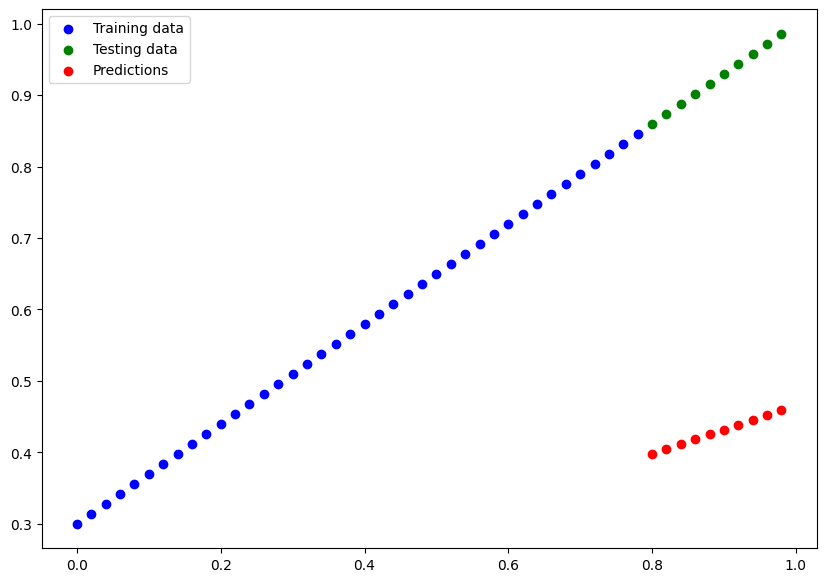

In [13]:
plot_predictions(predictions=y_preds)

## 3. Train model


The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *know* parameters.  

Or in other words from poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong our model predictions are, is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function**: A function to measuren how wrong the predictions are compared to the ideal output. The lower the better. 
* **Optimize.**: Takes into account the loss of the model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function.
    * Inside the optimizer one'll often have to set two parameters:
        * `params` - the model parameters one would like to optimize, for example `params=model_0.parameters()`
        * `lr` - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [14]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (SGD)
optimizer = torch.optim.SGD(
    model_0.parameters(), 
    lr=0.01)

**Q**: Which loss function and opimizer should i use?  
**A**: This will be problem specific. But with experience, one'll get an idea of what works and what does not with your particular problem set.

For example, for a regression problem (like this one), a loss function of `nn.L1Loss` and an optimizer like `torch.optim.SGD()` will suffice.  
But for a classification problem like classfying whether a photo is of a dog or a cat, one will likely want to use a loss function of `nn.BCELoss()` (binary cross entropy loss).

### Building a training (and testing) loop in PyTorch

A couple of things we need in a training loop:

0. Loop through the data and do the following: 
1. Forward pass (this involves data moving throuwh our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - Use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [15]:
torch.manual_seed(42)

# An epoch is one loop through the entire dataset ... (this is a hyperparameter because we set it ourselves)
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

## Training the model
# 0. Loop through the data
for epoch in range(epochs):
    model_0.train() # Set the model to train mode: Sets all parameters that require gradients to require gradients

    y_pred = model_0(X_train) # Make predictions
    
    loss = loss_fn(y_train, y_pred) # Calculate the loss

    optimizer.zero_grad() # Zero the gradients

    loss.backward() # Calculate gradients

    optimizer.step() # Update the weights

    # Testing / Evaulating the model
    model_0.eval() # Turns off different settings, which are not needed for testing/evaluation
    with torch.inference_mode(): # Turns off gradient tracking
        test_preds = model_0(X_test)  

        test_loss = loss_fn(y_test, test_preds)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        
        print(f"Epoch: {epoch} --- Loss: {loss} --- Test loss: {test_loss}") 
        print(f"Model state_dict: {model_0.state_dict()}")

Epoch: 0 --- Loss: 0.31288138031959534 --- Test loss: 0.48106518387794495
Model state_dict: OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 10 --- Loss: 0.1976713240146637 --- Test loss: 0.3463551998138428
Model state_dict: OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})
Epoch: 20 --- Loss: 0.08908725529909134 --- Test loss: 0.21729660034179688
Model state_dict: OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})
Epoch: 30 --- Loss: 0.053148526698350906 --- Test loss: 0.14464017748832703
Model state_dict: OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})
Epoch: 40 --- Loss: 0.04543796554207802 --- Test loss: 0.11360953003168106
Model state_dict: OrderedDict({'weights': tensor([0.4748]), 'bias': tensor([0.3868])})
Epoch: 50 --- Loss: 0.04167863354086876 --- Test loss: 0.09919948130846024
Model state_dict: OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})
Epoch: 60 --- Loss: 0.03818932

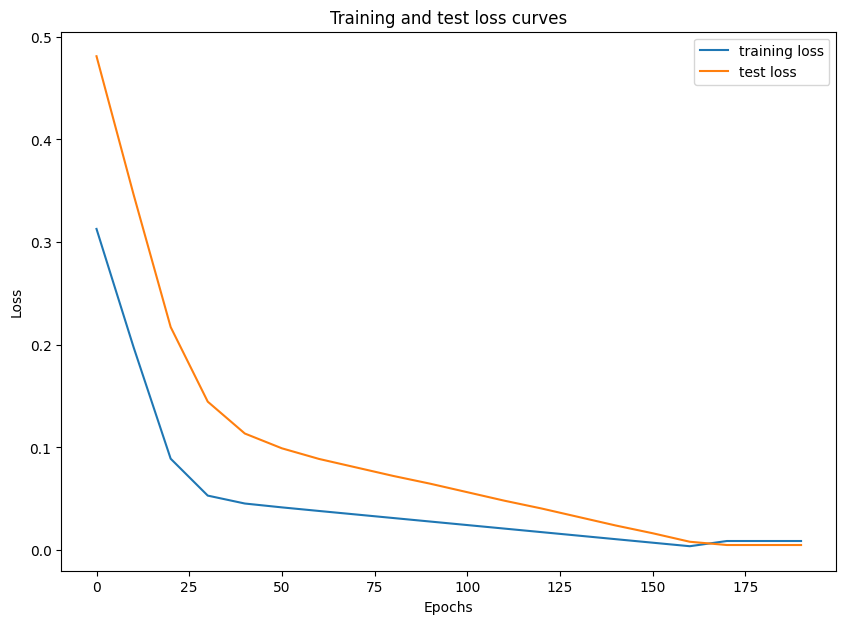

In [16]:
# Plot the loss values over the epochs
plt.figure(figsize=(10, 7))
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label='training loss')
plt.plot(epoch_count, test_loss_values, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and test loss curves')
plt.legend()
plt.show()


In [17]:
with torch.inference_mode():
    y_preds_after_training = model_0(X_test)

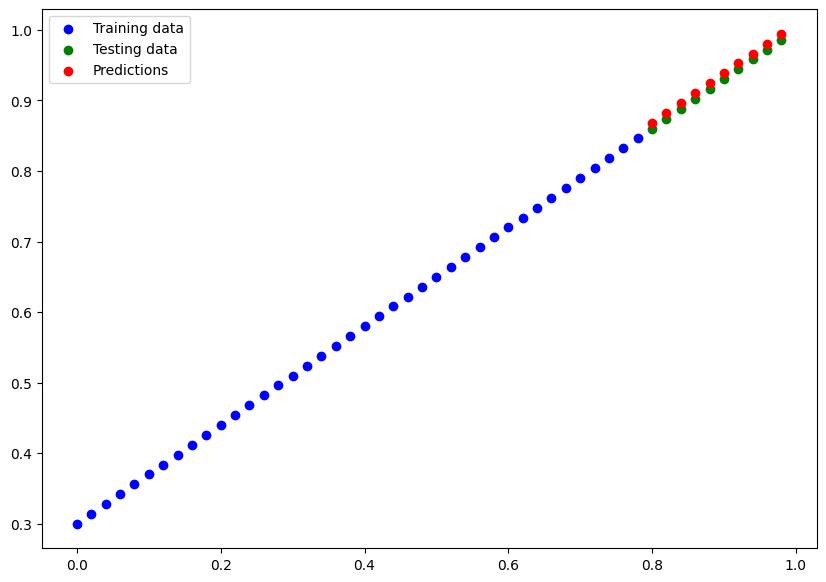

In [18]:
plot_predictions(predictions=y_preds_after_training)

## Saving a model in PyTorch

There are three main methods one should know about for saving and loading models in PyTorsch.

1. `torch.save()` - allows you to save a PyTorch object in Python's .pkl-Format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a  model's saved state dictionary.

In [19]:
# 1. Create a directory to save the model
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save model's state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(
    obj=model_0.state_dict(), 
    f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [20]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [21]:
loaded_model_0.state_dict(), model_0.state_dict()

(OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]),
 OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]))

In [22]:
# Moke some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [23]:
# Compare loaded model preds with original model preds
y_preds_after_training == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place.

In [24]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

In [25]:
# Check PyTorch version
torch.__version__

'2.6.0+cpu'

Create device-agrostic code.

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using the CPU.

In [26]:
# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


### 6.1 Data

In [27]:
# Create some data using the linear regression equation y = wx + b
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [28]:
# Split the data into training and test sets
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

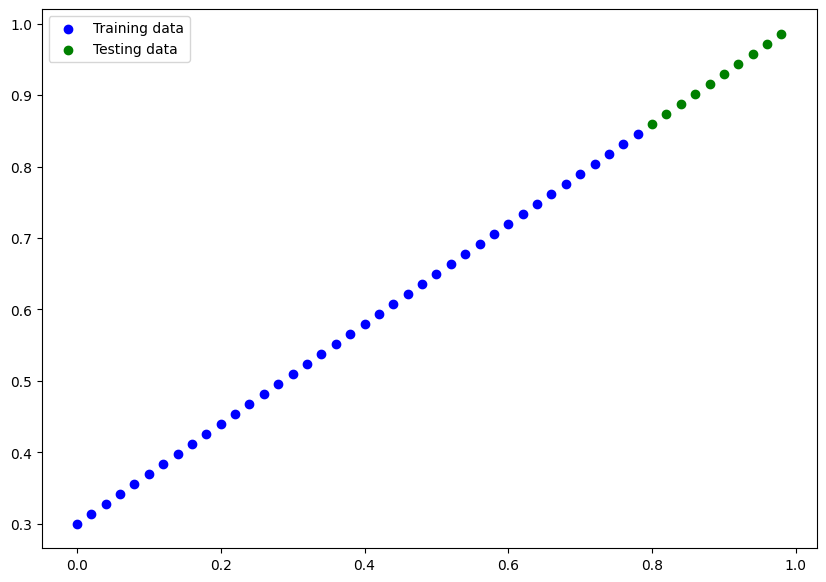

In [29]:
# Plot the data
# Note: If you do not have the plot_predictions() function loaded, the call will fail
plot_predictions(train_data=X_train, 
                 train_labels=y_train, 
                 test_data=X_test, 
                 test_labels=y_test)

### 6.2 Building a PyTorch Linear Model

In [30]:
# Create a linear regression model by subclassing nn.Module
class LinearRegressionModel_2(nn.Module):
    """A simple linear regression model."""
    
    def __init__(self):
        super().__init__()
        # Use nn.Linear() to create the model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [31]:
# Set manual seed for reproducibility
torch.manual_seed(42)
model_1 = LinearRegressionModel_2()
model_1, model_1.state_dict()

(LinearRegressionModel_2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [32]:
# Set the model to use the target device
model_1.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

### 6.3 Train the model

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [33]:
# Setup Loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [34]:
# Training loop
torch.manual_seed(42)

epochs = 201

for epoch in range(epochs):
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_train, y_pred)

    # 3. Zero the gradients
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Update the weights
    optimizer.step()

    # Testing loop
    model_1.eval()

    with torch.inference_mode():
        test_preds = model_1(X_test)

        test_loss = loss_fn(y_test, test_preds)

    # Print out whats happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} --- Loss: {loss} --- Test loss: {test_loss}")

Epoch: 0 --- Loss: 0.5551779866218567 --- Test loss: 0.5739762187004089
Epoch: 10 --- Loss: 0.4399680495262146 --- Test loss: 0.4392663538455963
Epoch: 20 --- Loss: 0.3247582018375397 --- Test loss: 0.30455657839775085
Epoch: 30 --- Loss: 0.20954827964305878 --- Test loss: 0.16984674334526062
Epoch: 40 --- Loss: 0.09433844685554504 --- Test loss: 0.03513689711689949
Epoch: 50 --- Loss: 0.023886386305093765 --- Test loss: 0.04784906655550003
Epoch: 60 --- Loss: 0.0199567973613739 --- Test loss: 0.04580312222242355
Epoch: 70 --- Loss: 0.016517987474799156 --- Test loss: 0.0375305712223053
Epoch: 80 --- Loss: 0.013089170679450035 --- Test loss: 0.029944902285933495
Epoch: 90 --- Loss: 0.009653178043663502 --- Test loss: 0.02167237363755703
Epoch: 100 --- Loss: 0.006215679459273815 --- Test loss: 0.014086711220443249
Epoch: 110 --- Loss: 0.002787243574857712 --- Test loss: 0.005814164876937866
Epoch: 120 --- Loss: 0.0012645035749301314 --- Test loss: 0.013801807537674904
Epoch: 130 --- Los

In [35]:
model_1.state_dict(), device

(OrderedDict([('linear_layer.weight', tensor([[0.6929]])),
              ('linear_layer.bias', tensor([0.2925]))]),
 'cpu')

### 6.4 Making and evaluating predictions

In [36]:
# Turn the model into evaluation mode
model_1.eval()

# Make predictions with the test data
with torch.inference_mode():
    y_preds_after_training = model_1(X_test)
y_preds_after_training

tensor([[0.8468],
        [0.8607],
        [0.8746],
        [0.8884],
        [0.9023],
        [0.9161],
        [0.9300],
        [0.9438],
        [0.9577],
        [0.9716]])

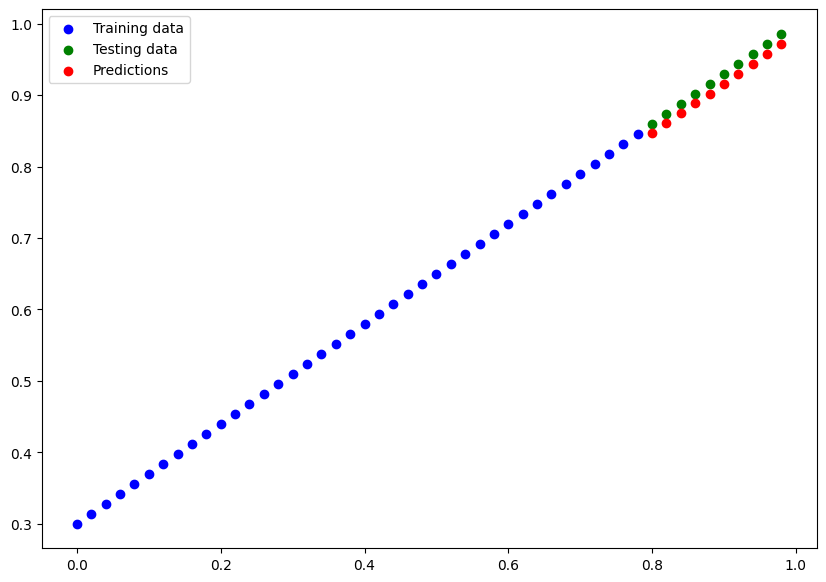

In [37]:
# Plot the predictions
plot_predictions(predictions=y_preds_after_training.to("cpu"))

### 6.5 Save and load

In [38]:
from pathlib import Path

# 1. Create a directory to save the model
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model's state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(
    obj=model_1.state_dict(), 
    f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_1.pth


In [39]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6929]])),
             ('linear_layer.bias', tensor([0.2925]))])

In [40]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_1 = LinearRegressionModel_2()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put it to device
loaded_model_1.to(device)

LinearRegressionModel_2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [41]:
# Make predictions with loaded model
loaded_model_1.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_1(X_test)
loaded_model_preds

tensor([[0.8468],
        [0.8607],
        [0.8746],
        [0.8884],
        [0.9023],
        [0.9161],
        [0.9300],
        [0.9438],
        [0.9577],
        [0.9716]])

In [42]:
loaded_model_preds == y_preds_after_training

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

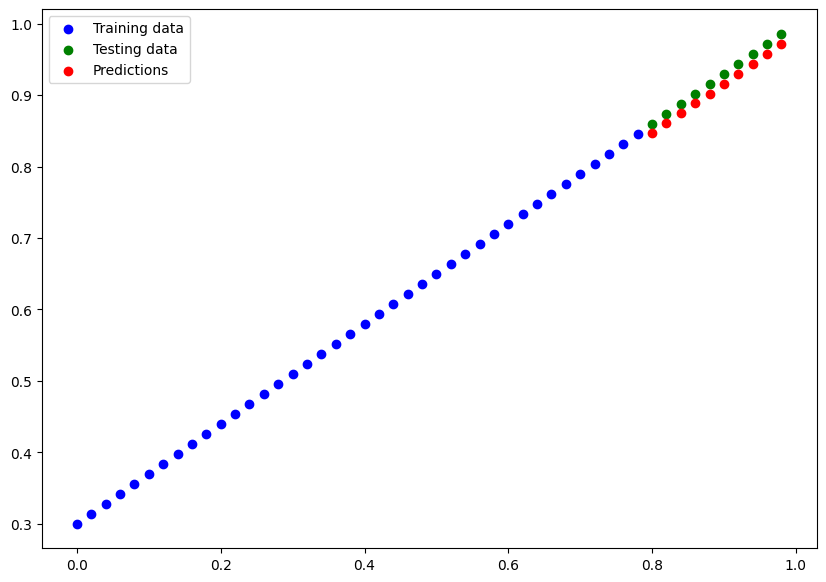

In [43]:
# plot the predictions
plot_predictions(predictions=loaded_model_preds.to("cpu"))